In [1]:
import numpy as np
import scipy.stats
from aisynphys.database import default_db as db
from aisynphys.cell_class import CellClass, classify_cells, classify_pairs
from aisynphys.connectivity import measure_connectivity, pair_was_probed

In [2]:
# Download and cache the sqlite file for the requested database
#   (for available versions, see SynphysDatabase.list_versions)
#db = SynphysDatabase.load_version('synphys_r1.0_2019-08-29_small.sqlite')

# Load all synapses associated with mouse V1 projects
pairs = db.pair_query(
    project_name=["mouse V1 coarse matrix", "mouse V1 pre-production"],
    synapse=True,
).all()

print("loaded %d synapses" % len(pairs))

loaded 1441 synapses


In [3]:
cell_class_criteria = {
    'l23pyr': {'dendrite_type': 'spiny', 'target_layer': '2/3'},
    'l4pyr':  {'cre_type': 'nr5a1'},
    'l5et':   {'cre_type': ('sim1', 'fam84b')},
    'l5it':   {'cre_type': 'tlx3'}, 
    'l6pyr':  {'cre_type': 'ntsr1'},
    'pv':     {'cre_type': 'pvalb'},
    'sst':    {'cre_type': 'sst'},
    'vip':    {'cre_type': 'vip'},  
}

cell_classes = {name:CellClass(name=name, **criteria) for name,criteria in cell_class_criteria.items()}

In [4]:
# get a list of all cells in the selected pairs
cells = set([pair.pre_cell for pair in pairs] + [pair.post_cell for pair in pairs])

# Classify each cell. Note that, depending on the class definitions above, a cell could 
# belong to multiple classes. 
cell_class = {}
for cell in cells:
    # which of the classes defined above is this cell a member of?
    cell_in_classes = [cls_name for cls_name, cls in cell_classes.items() if cell in cls]
    cell_class[cell] = ','.join(cell_in_classes)

In [5]:
import pandas

# construct a pandas dataframe containing the pre/postsynaptic cell class names
# and a measure of short-term plasticity
pre_class = [cell_class[pair.pre_cell] for pair in pairs]
post_class = [cell_class[pair.post_cell] for pair in pairs]
stp = [None if pair.dynamics is None else pair.dynamics.stp_induction_50hz for pair in pairs]

df = pandas.DataFrame(
    zip(pairs, pre_class, post_class, stp), 
    columns=['pair', 'pre_class', 'post_class', 'stp']) 

# select out only cells that are a member of exactly 1 class
mask = df.pre_class.isin(cell_classes) & df.post_class.isin(cell_classes)
df = df[mask]

# select only pairs with a measured stp
df = df.dropna()

df.head()

,pair,pre_class,post_class,stp
2,<Pair 1555444699.177 3 7>,pv,l5it,-0.662970
5,<Pair 1555444699.177 3 2>,pv,l5it,-0.530220
6,<Pair 1555444699.177 2 3>,l5it,pv,-0.262190
13,<Pair 1493679882.330 4 3>,pv,pv,-0.445864
15,<Pair 1493159586.902 3 5>,pv,pv,-0.634465


In [6]:
stp = df.pivot_table('stp', 'pre_class', 'post_class', aggfunc=np.mean)

# sort rows/cols into the expected order
order = list(cell_classes)
stp = stp[order].loc[order]

stp

post_class,l23pyr,l4pyr,l5et,l5it,l6pyr,pv,sst,vip
pre_class,,,,,,,,
l23pyr,0.011103,NaN,NaN,NaN,NaN,-0.075963,0.178587,0.074199
l4pyr,NaN,-0.179534,NaN,NaN,NaN,-0.266820,0.284628,-0.069865
l5et,NaN,NaN,-0.400509,NaN,NaN,-0.629479,0.226546,NaN
l5it,NaN,NaN,-0.239228,-0.234780,NaN,-0.318248,0.142883,-0.345139
l6pyr,NaN,NaN,NaN,NaN,-0.216613,0.092806,0.136302,NaN
pv,-0.452121,-0.498468,-0.509792,-0.539136,-0.316731,-0.359374,-0.302323,-0.311318
sst,-0.248630,-0.271568,-0.225119,-0.110278,-0.048876,-0.118122,-0.135682,0.120770
vip,-0.093003,NaN,NaN,NaN,NaN,-0.105766,-0.013254,-0.151366


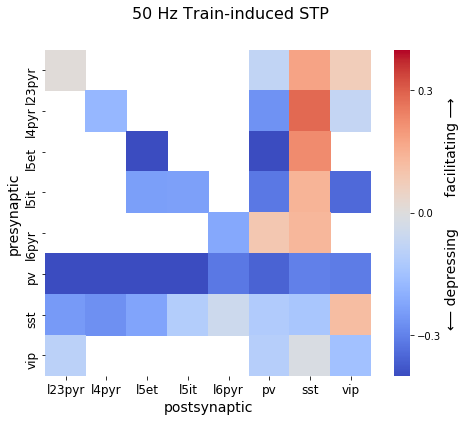

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig,ax = plt.subplots(figsize=(8, 6))

hm = sns.heatmap(stp, cmap='coolwarm', vmin=-0.4, vmax=0.4, square=True, ax=ax,
                cbar_kws={"ticks":[-0.3, 0, 0.3], 'label': '⟵ depressing       facilitating ⟶'})

fig.suptitle("50 Hz Train-induced STP", fontsize=16)
hm.set_xlabel("postsynaptic", fontsize=14)
hm.set_ylabel("presynaptic", fontsize=14);
hm.figure.axes[-1].yaxis.label.set_size(14)
hm.tick_params(labelsize=12)

In [8]:
# query once for each postsynaptic type, building up a Pandas dataframe

pairs = None
pair_classes = [
    ('l23pyr', 'l23pyr'),
    ('l23pyr', 'vip'),
    
    ('l4pyr', 'sst'),
    
    ('l5et', 'l5et'),
    ('l5et', 'pv'),

    ('l6pyr', 'pv'),
    ('l6pyr', 'sst'),
    
    ('pv', 'l5et'),
    ('pv', 'l5it'),
    
    ('sst', 'l6pyr'),
    ('sst', 'vip'),
    
    ('vip', 'l23pyr'),
    ('vip', 'vip'),
]
for pre_name, post_name in pair_classes:
    pre_class = cell_classes[pre_name]
    post_class = cell_classes[post_name]
    pair_query = db.pair_query(
        project_name=["mouse V1 coarse matrix", "mouse V1 pre production"],
        pre_class=pre_class,
        post_class=post_class,
        synapse=True,
    )
    pair_query = pair_query.add_columns(
        db.Dynamics.stp_initial_50hz,
        db.Dynamics.stp_induction_50hz,
        db.Dynamics.stp_recovery_250ms,
    )
    
    df = pair_query.dataframe()
    df['pre_class'] = pre_name
    df['post_class'] = post_name
    df['pair_class'] = pre_name + "→" + post_name
    if pairs is None:
        pairs = df
    else:
        pairs = pairs.append(df)
    print("%s->%s: %d synapses" % (pre_name, post_name, len(df)))

l23pyr->l23pyr: 4 synapses
l23pyr->vip: 10 synapses
l4pyr->sst: 2 synapses
l5et->l5et: 16 synapses
l5et->pv: 4 synapses
l6pyr->pv: 11 synapses
l6pyr->sst: 10 synapses
pv->l5et: 12 synapses
pv->l5it: 11 synapses
sst->l6pyr: 4 synapses
sst->vip: 34 synapses
vip->l23pyr: 2 synapses
vip->vip: 14 synapses


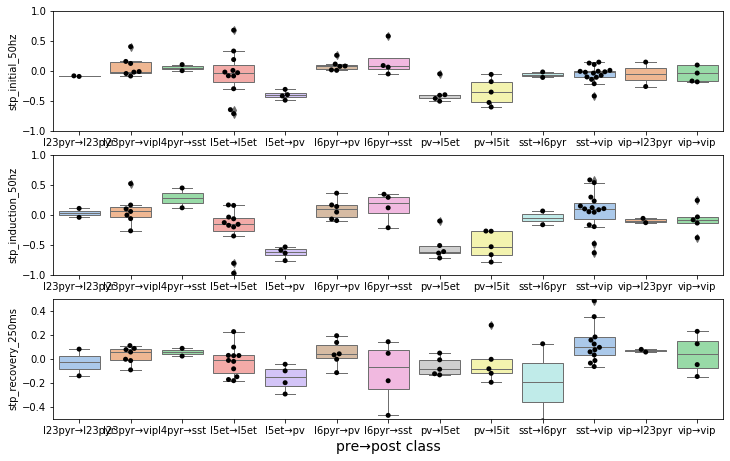

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

limits = {
    'stp_initial_50hz': (-1, 1),
    'stp_induction_50hz': (-1, 1),
    'stp_recovery_250ms': (-0.5, 0.5),
}
units = ['ms', 'ms', 'ms', 'mV']
ticks = {
    'ms': 0.5e-3 * 2**np.arange(4),
    'mV': 20e-6 * 4**np.arange(4),
}

fig,ax = plt.subplots(len(limits), 1, figsize=(12, 2.5 * len(limits)))


for i, (field, lim) in enumerate(limits.items()):
    # box and swarm plots
    #ax[i].set_yscale('log')
    ax[i].set_ylim(*lim)
    sns.boxplot(x="pair_class", y=field, data=pairs, ax=ax[i], palette='pastel', width=0.8, linewidth=1)
    sns.swarmplot(x="pair_class", y=field, data=pairs, ax=ax[i], size=5, color=(0, 0, 0, 0.5))
    
    # clean up labels / ticks
    if i == len(limits)-1:
        ax[i].set_xlabel('pre→post class', size=14)
    else:
        ax[i].set_xlabel('')
    #ax[i].set_ylabel(field.replace('_', ' ') + ' (%s)'%units[i], size=12)
    #ax[i].set_yticks(ticks[units[i]])
    #ax[i].set_yticklabels(['%0.2f' % (x*1000) for x in ticks[units[i]]])
    ax[i].set_yticklabels([], minor=True)

/home/luke/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


TypeError: '<' not supported between instances of 'NoneType' and 'NoneType'

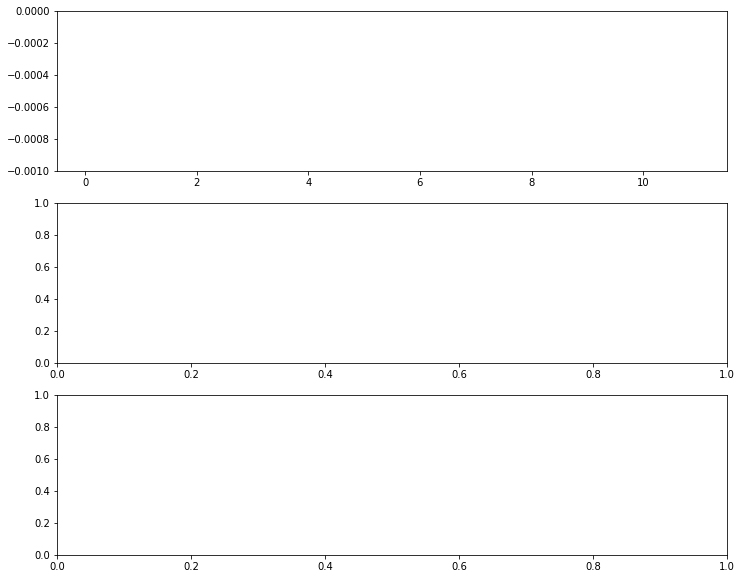

In [12]:
pairs = [
    ('1539987094.832', ('3', '6')),
   #('1525985474.422', ('3', '4')),
]

fig,ax = plt.subplots(3, 1, figsize=(12, 10))

for pair_i, (expt_id, pair_id) in enumerate(pairs):
    pair = db.experiment_from_ext_id(expt_id).pairs[pair_id]
    qc_field = pair.synapse.synapse_type + '_qc_pass'

    q = db.query(
        db.PulseResponseFit.fit_amp,
        getattr(db.PulseResponse, qc_field).label('qc_pass'),
        db.StimPulse.pulse_number,
        db.MultiPatchProbe.induction_frequency,
        db.MultiPatchProbe.recovery_delay,
        db.SyncRec.ext_id.label('sync_rec_ext_id'),
    )
    q = q.join(db.PulseResponse, db.PulseResponseFit.pulse_response)
    q = q.join(db.Recording, db.PulseResponse.recording)
    q = q.join(db.SyncRec, db.Recording.sync_rec)
    q = q.join(db.PatchClampRecording, db.Recording.patch_clamp_recording)
    q = q.join(db.MultiPatchProbe, db.PatchClampRecording.multi_patch_probe)
    q = q.join(db.StimPulse, db.PulseResponse.stim_pulse)
    q = q.join(db.Experiment, db.SyncRec.experiment)
    q = q.join(db.Pair, db.PulseResponse.pair)
    q = q.join(db.Synapse, db.Pair.synapse)
    q = q.filter(db.Pair.id==pair.id)
    q = q.filter(db.PatchClampRecording.clamp_mode=='ic')
    q = q.order_by(db.SyncRec.ext_id, db.StimPulse.pulse_number)

    data = q.dataframe()
    
    # generate a list of all trains sorted by stimulus
    trains = {}  # {ind_f: {rec_d: [[a1, a2, ..a12], [b1, b2, ..b12], ...], ...}, ...}
    current_sweep = None
    skip_sweep = False
    current_train = []
    for i in range(len(data)):
        sweep_id = data['sync_rec_ext_id'][i]
        ind_f = data['induction_frequency'][i]
        rec_d = data['recovery_delay'][i]
        if sweep_id != current_sweep:
            skip_sweep = False
            current_sweep = sweep_id
            current_train = []
            ind_trains = trains.setdefault(ind_f, {})
            rec_trains = ind_trains.setdefault(rec_d, [])
            rec_trains.append(current_train)
        if skip_sweep:
            continue
        if not data['qc_pass'][i]:
            skip_sweep = True
            continue
        current_train.append(data['fit_amp'][i])
        
    qc_pass_data = data[data['qc_pass']]

    # scatter plots of event amplitudes sorted by pulse number
    ind_f = 50
    
    ax[pair_i].set_ylim(-1e-3, 0)
    mask = data['induction_frequency'] == ind_f
    filtered = qc_pass_data[mask]
#     sns.boxplot(x='pulse_number', y='fit_amp', data=filtered, ax=ax[ind_i], palette='pastel', width=0.8, linewidth=1)
    sns.swarmplot(x='pulse_number', y='fit_amp', data=filtered, color='k', ax=ax[pair_i])

    ind_trains = trains.get(ind_f, {})

    # collect all induction events by pulse number
    ind_pulses = [[] for i in range(12)]
    for rec_d, rec_trains in ind_trains.items():
        for train in rec_trains:
            for i,amp in enumerate(train):
                if np.isfinite(amp):
                    ind_pulses[i].append(amp)

    pulse_means = [np.mean(ip) for ip in ind_pulses]
    ax[pair_i].plot(pulse_means)
    #     x = []
    #     y = []
    #     for i in range(12):
    #         if len(ind_pulses[i]) == 0:
    #             continue
    #         y.extend(ind_pulses[i])
    #         xs = pg.pseudoScatter(np.array(ind_pulses[i]), bidir=True, shuffle=True)
    #         xs /= np.abs(xs).max() * 4
    #         x.extend(xs + i)

    #     self.ind_plots[ind_i].clear()
    #     self.ind_plots[ind_i].plot(x, y, pen=None, symbol='o')


In [13]:
filtered

,fit_amp,qc_pass,pulse_number,induction_frequency,recovery_delay,sync_rec_ext_id
73,None,True,2,50.0,0.128,36
74,None,True,3,50.0,0.128,36
75,None,True,4,50.0,0.128,36
76,None,True,5,50.0,0.128,36
77,None,True,6,50.0,0.128,36
78,None,True,7,50.0,0.128,36
79,None,True,8,50.0,0.128,36
81,None,True,10,50.0,0.128,36
82,None,True,11,50.0,0.128,36
83,None,True,12,50.0,0.128,36


In [ ]:
pulse_means

In [ ]:
ind_pulses